In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from os import walk
import datetime
from tqdm import tqdm
from numba import jit  
from sklearn.preprocessing import MinMaxScaler
import datetime as dtm
import lightgbm as lgb
from sklearn import preprocessing, metrics
import seaborn as sns
import time
import warnings
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
warnings.filterwarnings("ignore")

In [2]:
train=pd.read_csv('Data/train.csv',',')
test=pd.read_csv('Data/test.csv',',')

In [3]:
train.head(3)

,city,floor,id,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,...,reform_mean_floor_count_1000,reform_mean_floor_count_500,reform_mean_year_building_1000,reform_mean_year_building_500,region,total_square,street,date,realty_type,price_type
0,Пермь,NaN,COL_0,57.998207,56.292797,4,19,35,52,0,...,5.762963,5.530612,1964.118519,1960.959184,Пермский край,32.0,S27289,2020-01-05,10,0
1,Шатура,NaN,COL_1,55.574284,39.543835,3,24,37,59,0,...,2.894366,3.527778,1952.321678,1957.222222,Московская область,280.0,S17052,2020-01-05,10,0
2,Ярославль,NaN,COL_2,57.619140,39.850525,1,30,67,128,0,...,6.141414,7.222222,1968.150000,1973.370370,Ярославская область,297.4,S16913,2020-01-05,110,0


In [4]:
test.head(3)

,city,floor,id,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,osm_building_points_in_0.005,osm_building_points_in_0.0075,...,reform_mean_year_building_1000,reform_mean_year_building_500,region,lat,lng,total_square,street,date,realty_type,price_type
0,Курск,1.0,COL_289284,7,55,85,117,0,0,0,...,1966.471591,1966.740260,Курская область,51.709255,36.147908,156.148996,S6983,2020-09-06,100,1
1,Сургут,1.0,COL_289305,8,70,112,140,0,0,0,...,1988.259259,1989.068182,Ханты-Мансийский АО,61.233240,73.462509,190.737943,S29120,2020-09-06,110,1
2,Тюмень,-1.0,COL_289318,3,28,67,122,0,0,0,...,1985.880282,1991.458333,Тюменская область,57.143110,65.554573,457.118051,S23731,2020-09-06,10,1


# CREATE FEAS AND PREPARE DATASET

In [5]:
predictors=['floor_id','city_id','lat','lng','osm_amenity_points_in_0.001',
       'osm_amenity_points_in_0.005', 'osm_amenity_points_in_0.0075',
       'osm_amenity_points_in_0.01', 'osm_building_points_in_0.001',
       'osm_building_points_in_0.005', 'osm_building_points_in_0.0075',
       'osm_building_points_in_0.01', 'osm_catering_points_in_0.001',
       'osm_catering_points_in_0.005', 'osm_catering_points_in_0.0075',
       'osm_catering_points_in_0.01', 'osm_city_closest_dist', 'osm_city_nearest_population',
       'osm_crossing_closest_dist', 'osm_crossing_points_in_0.001',
       'osm_crossing_points_in_0.005', 'osm_crossing_points_in_0.0075',
       'osm_crossing_points_in_0.01', 'osm_culture_points_in_0.001',
       'osm_culture_points_in_0.005', 'osm_culture_points_in_0.0075',
       'osm_culture_points_in_0.01', 'osm_finance_points_in_0.001',
       'osm_finance_points_in_0.005', 'osm_finance_points_in_0.0075',
       'osm_finance_points_in_0.01', 'osm_healthcare_points_in_0.005',
       'osm_healthcare_points_in_0.0075', 'osm_healthcare_points_in_0.01',
       'osm_historic_points_in_0.005', 'osm_historic_points_in_0.0075',
       'osm_historic_points_in_0.01', 'osm_hotels_points_in_0.005',
       'osm_hotels_points_in_0.0075', 'osm_hotels_points_in_0.01',
       'osm_leisure_points_in_0.005', 'osm_leisure_points_in_0.0075',
       'osm_leisure_points_in_0.01', 'osm_offices_points_in_0.001',
       'osm_offices_points_in_0.005', 'osm_offices_points_in_0.0075',
       'osm_offices_points_in_0.01', 'osm_shops_points_in_0.001',
       'osm_shops_points_in_0.005', 'osm_shops_points_in_0.0075',
       'osm_shops_points_in_0.01', 'osm_subway_closest_dist',
       'osm_train_stop_closest_dist', 'osm_train_stop_points_in_0.005',
       'osm_train_stop_points_in_0.0075', 'osm_train_stop_points_in_0.01',
       'osm_transport_stop_closest_dist',
       'osm_transport_stop_points_in_0.005',
       'osm_transport_stop_points_in_0.0075',
       'osm_transport_stop_points_in_0.01','Year','month','day','price_type','realty_type','total_square']
target='per_square_meter_price'

In [6]:
train['region']

0                   Пермский край
1              Московская область
2             Ярославская область
3             Кемеровская область
4                          Москва
                   ...           
279787            Томская область
279788            Санкт-Петербург
279789    Калининградская область
279790        Кемеровская область
279791          Кировская область
Name: region, Length: 279792, dtype: object

In [7]:
#CITY DICT
cts=pd.DataFrame(train['city'].drop_duplicates().reset_index(drop=True))
cts['city_id']=cts.index
train=pd.merge(cts,train,how='left',on='city')
test=pd.merge(cts,test,how='left',on='city')
#FLOORS DICT
train['floor']=train['floor'].fillna(-1)
test['floor']=test['floor'].fillna(-1)
flr=pd.DataFrame(train['floor'].drop_duplicates().reset_index(drop=True))
flr['floor_id']=flr.index
train=pd.merge(flr,train,how='left',on='floor')
test=pd.merge(flr,test,how='left',on='floor')
#TIME FEAS
train['Date'],test['Date']=train['date'].astype('datetime64[ns]'),test['date'].astype('datetime64[ns]')
train['Year']=train['Date'].dt.year
train['month']=train['Date'].dt.month
train['day']=train['Date'].dt.day
test['Year']=test['Date'].dt.year
test['month']=test['Date'].dt.month
test['day']=test['Date'].dt.day
test.head(3)

,floor,floor_id,city,city_id,id,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,...,lng,total_square,street,date,realty_type,price_type,Date,Year,month,day
0,-1,0,Пермь,0.0,COL_301220,0.0,47.0,125.0,269.0,0.0,...,56.243041,6683.779613,S12321,2020-09-13,10.0,1.0,2020-09-13,2020.0,9.0,13.0
1,-1,0,Пермь,0.0,COL_307043,2.0,54.0,213.0,370.0,0.0,...,56.257829,98.848219,S20753,2020-09-13,100.0,1.0,2020-09-13,2020.0,9.0,13.0
2,-1,0,Пермь,0.0,COL_331559,0.0,47.0,134.0,270.0,0.0,...,56.241633,7229.268979,S12321,2020-10-04,100.0,1.0,2020-10-04,2020.0,10.0,4.0


In [8]:
def filter_data(df):
    result=[]
    for ct in tqdm(df['city'].drop_duplicates()):
        df_t=df[df['city']==ct]
        df_t=df_t[df_t[target]<df_t[target].mean()+(3*df_t[target].std())]
        df_t=df_t[df_t[target]>df_t[target].mean()-(3*df_t[target].std())]
        result.append(df_t)
    result=pd.concat(result).sort_values(by='Date').reset_index(drop=True)
    return(result)
train_filter=filter_data(train)
train_filter

100%|██████████| 4948/4948 [01:52<00:00, 44.11it/s]


,floor,floor_id,city,city_id,id,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,...,region,total_square,street,date,realty_type,price_type,Date,Year,month,day
0,-1,0,Пермь,0,COL_0,57.998207,56.292797,4,19,35,...,Пермский край,32.0,S27289,2020-01-05,10,0,2020-01-05,2020,1,5
1,-1,0,Котельниково,539,COL_3137,47.615560,43.143310,0,0,0,...,Волгоградская область,57.0,S20527,2020-01-05,110,0,2020-01-05,2020,1,5
2,-1,0,Новый Оскол,540,COL_3138,50.761080,37.868336,3,17,25,...,Белгородская область,37.0,S33268,2020-01-05,110,0,2020-01-05,2020,1,5
3,-1,0,Королев,100,COL_1387,55.927505,37.799976,1,6,12,...,Московская область,420.0,S28802,2020-01-05,10,0,2020-01-05,2020,1,5
4,-1,0,Королев,100,COL_2499,55.945084,37.839993,0,1,5,...,Московская область,52.3,S33709,2020-01-05,10,0,2020-01-05,2020,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274367,1,1,Екатеринбург,9,COL_275490,56.859154,60.618800,1,24,61,...,Свердловская область,32.1,S25848,2020-08-23,100,0,2020-08-23,2020,8,23
274368,1,1,Екатеринбург,9,COL_275857,56.833965,60.661460,5,34,72,...,Свердловская область,115.1,S10922,2020-08-23,110,0,2020-08-23,2020,8,23
274369,1,1,Екатеринбург,9,COL_275858,56.824203,60.625935,3,60,110,...,Свердловская область,205.0,S13735,2020-08-23,110,0,2020-08-23,2020,8,23
274370,1,1,Екатеринбург,9,COL_274725,56.835243,60.672333,1,22,48,...,Свердловская область,1429.0,S17733,2020-08-23,110,0,2020-08-23,2020,8,23


In [9]:
def cls_df(df,predictors):
    result=[]
    for ct in  tqdm(df['city'].drop_duplicates()):
        df_t=df[df['city']==ct]
        kmeans = KMeans(n_clusters=int(len(df_t)//2500)+1, random_state=0).fit(df_t[predictors])
        df_t['cluster']=kmeans.predict(df_t[predictors])
        result.append(df_t)
    result=pd.concat(result).sort_values(by='Date').reset_index(drop=True)
    return(result)
clss_flag=0

if(clss_flag==1):
    train_filter=cls_df(train_filter.fillna(-1),predictors)
    predictors.append('cluster')
    train_filter

LOG DATA


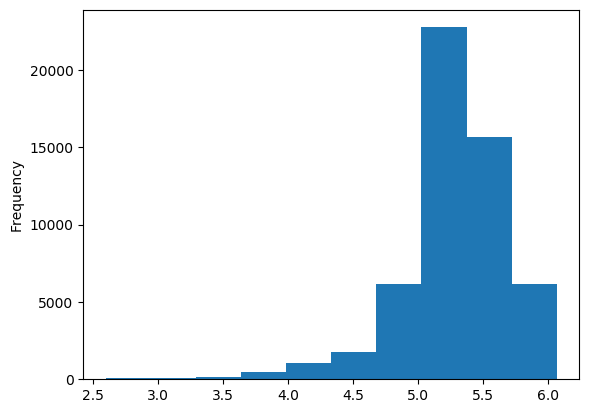

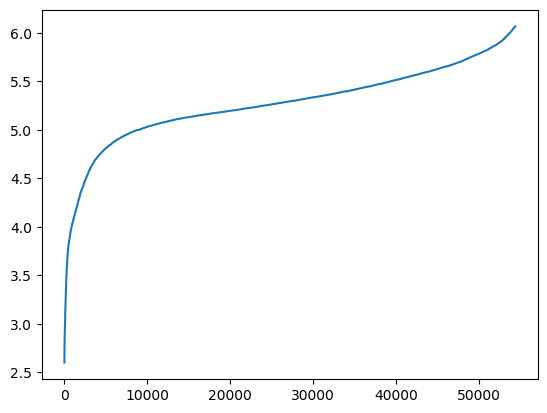

In [10]:
print('LOG DATA')
train=train_filter.copy()
train[target]=np.log10(train[target]+1)
distr=train[train['city']=='Москва']
distr[target].plot.hist()
plt.show()

distr=distr.sort_values(by=target)
plt.plot(distr[target].values)
plt.show()


In [11]:
train_filter.to_csv('train_filter.csv',';',index=False)

## scale data

In [28]:
def scale_data(df,target,cts):
    result=[]
    scale_dict={}
    for ct in tqdm(df['city'].drop_duplicates()):
        df_t=df[df['city']==ct].copy()
        scaler = MinMaxScaler()
        df_t[target]=scaler.fit_transform(df_t[target].values.reshape(-1,1))
        scale_dict[ct]=scaler
        result.append(df_t)
    result=pd.concat(result).sort_values(by='Date').reset_index(drop=True)
    return(df,scale_dict)

scale_flag=0
if(scale_flag==1):
    train_scaled,scale_dict=scale_data(train,target,cts)
else:
    train_scaled=train.copy()

## PCA

In [13]:
PCA_flag=0
if(PCA_flag==1):
    pca_breast = PCA(n_components=len(predictors))
    train_scaled_pca = pd.DataFrame(pca_breast.fit_transform(train_scaled[predictors].fillna(-1)))
    train_scaled_pca[target]=train_scaled[target]
    predictors=list(range(len(predictors)))
    train_scaled_pca.head(3)

## Split train

In [61]:
part1=0.75
part2=0.2
part2=part1+part2
if(PCA_flag==1):
    trn,val,tst=train_scaled_pca[:int(len(train)*part1)],train_scaled_pca[int(len(train)*part1):int(len(train)*part2)],train_scaled_pca[int(len(train)*part2):]
else:
    trn,val,tst=train_scaled[:int(len(train_scaled)*part1)],train_scaled[int(len(train_scaled)*part1):int(len(train_scaled)*part2)],train_scaled[int(len(train_scaled)*part2):]
train_X,train_y=trn[predictors],trn[target]
val_X,val_y=val[predictors],val[target]
test_X,test_y=tst[predictors],tst[target]

# MODEL

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.10031	valid_1's l2: 0.106201
[200]	training's l2: 0.0962155	valid_1's l2: 0.103444
[300]	training's l2: 0.0931246	valid_1's l2: 0.101357
[400]	training's l2: 0.0909703	valid_1's l2: 0.100031
[500]	training's l2: 0.0888668	valid_1's l2: 0.0988006
[600]	training's l2: 0.0875193	valid_1's l2: 0.0979679
[700]	training's l2: 0.0862824	valid_1's l2: 0.0973244
[800]	training's l2: 0.0854038	valid_1's l2: 0.0968724
[900]	training's l2: 0.0843311	valid_1's l2: 0.096282
[1000]	training's l2: 0.0834149	valid_1's l2: 0.0957729
[1100]	training's l2: 0.0825976	valid_1's l2: 0.0952938
[1200]	training's l2: 0.0821113	valid_1's l2: 0.0950613
[1300]	training's l2: 0.081653	valid_1's l2: 0.0948401
[1400]	training's l2: 0.0812991	valid_1's l2: 0.0946364
[1500]	training's l2: 0.0811155	valid_1's l2: 0.0945333
[1600]	training's l2: 0.0808089	valid_1's l2: 0.0943542
[1700]	training's l2: 0.0804691	valid_1's l2: 0.0941771
[18

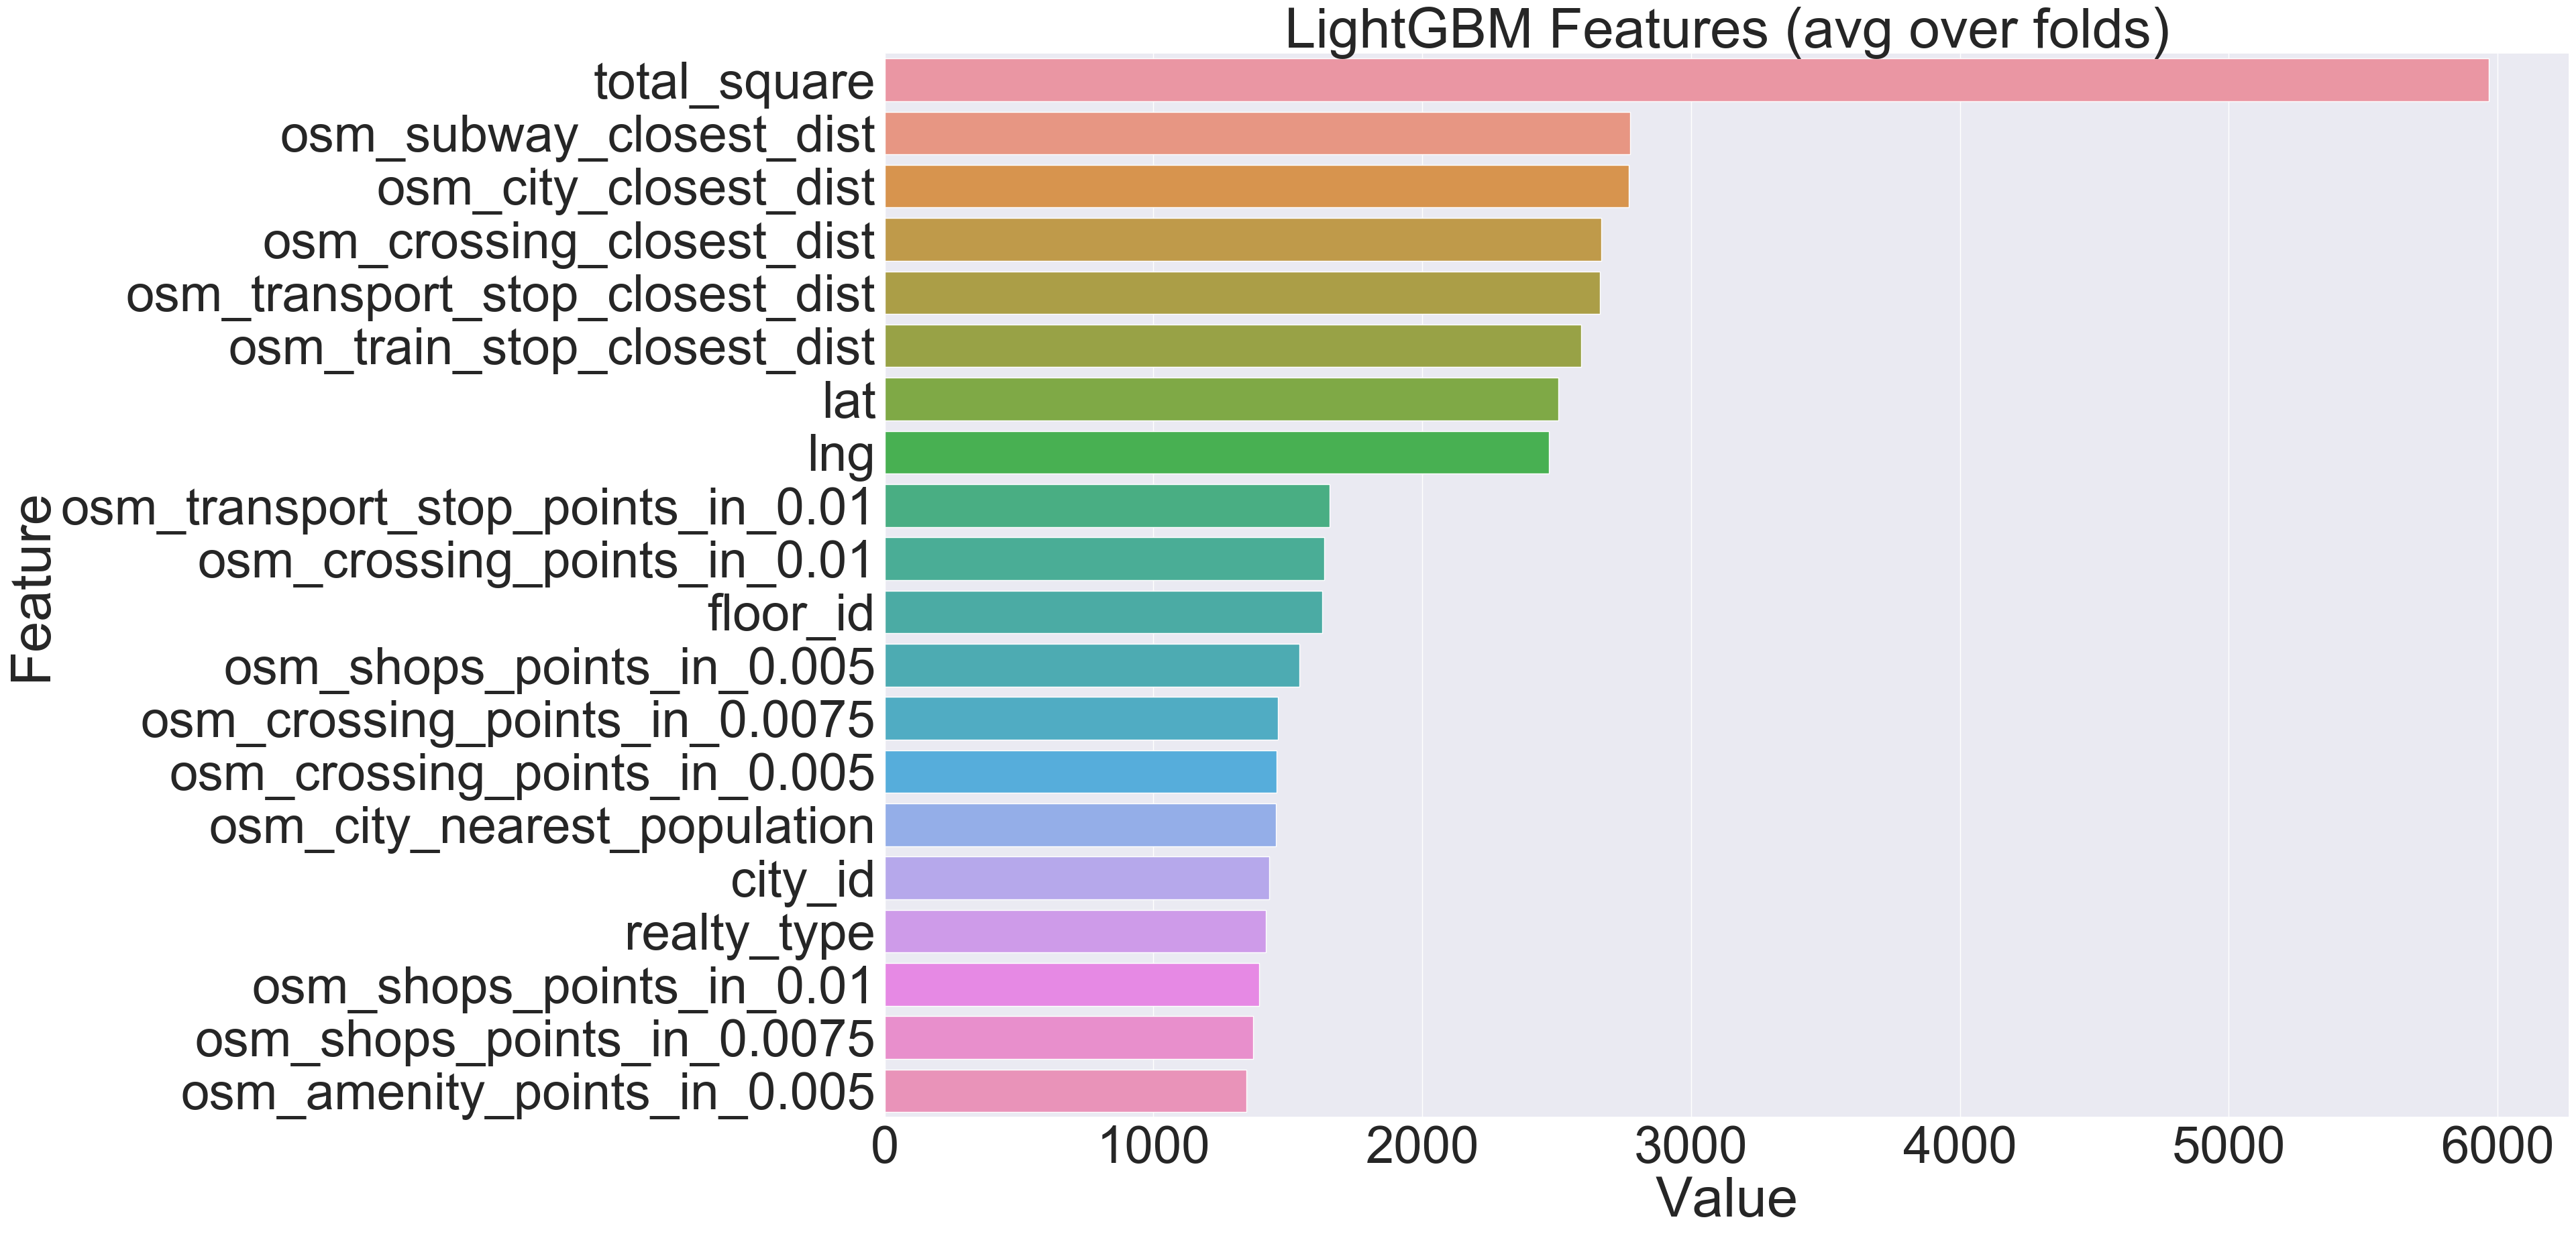

In [64]:
def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

def metric_calc(df,target):
    df['dev']=(df['Predict']-df[target])/df[target]
    accur=[]
    w=1.1
    for index,row in df.iterrows():
        if(row['dev']<-0.6):
            accur.append(9*w)
        elif((row['dev']>=-0.6)&(row['dev']<-0.15)):
            accur.append(w*(1+(row['dev']/0.15))**2)
        elif((row['dev']>=-0.15)&(row['dev']<0.15)):
            accur.append(0)
        elif((row['dev']>=0.15)&(row['dev']<0.6)):
            accur.append(((row['dev']/0.15)-1)**2)
        elif(row['dev']>=0.6):
            accur.append(9)
    df['accur']=accur
    accur=df['accur'].sum()/len(df['accur'])
    print('ACCURACY WEIGHT: '+str(accur))
    return()




def FitGBM(X_train,Y_train, X_val, Y_val,test,boost='goss',obj='mae',depth=-1):
    step=0.15   
    if(obj=='tweedie'):
        metric='tweedie'
    elif(obj=='mae'):
        metric='mse'
    elif(obj=='mape'):
        metric='mape'
    elif(obj=='huber'):
        metric='huber'
    elif(obj=='poisson'):
        metric='mse'
    elif(obj=='quantile'):
        metric='quantile'
    elif(obj=='fair'):
        metric='fair'
        
    params = {
        'boosting_type': boost,
        'metric': metric,
        'objective': obj,
        'n_jobs': -1,
        'seed':25,
        'learning_rate':step,
        'n_estimators':50000,
        'max_depth':depth,
        #'num_leaves':2**depth,
        #'extra_trees':True,
        #'verbose':-1
        }
    
    train_set = lgb.Dataset(X_train, Y_train)
    val_set = lgb.Dataset(X_val, Y_val)
    gbm = lgb.train(params,train_set, # learning_rates=lambda iter: step * (0.995 ** iter),
     early_stopping_rounds = 100, valid_sets = [train_set, val_set], verbose_eval = 100)
    print('Validate model LOG')
    test['Predict']=gbm.predict(test[predictors])
    Accuracy= np.round(1 - \
                            (np.abs(test[target]-test['Predict']
                                    ).sum()/test[target].sum()),2)*100
    print('Model Accuracy: '+str(Accuracy))
    print('Validate model UNLOG')
    test['Predict']=10**gbm.predict(test[predictors])-1
    test['target_unlog']=10**test[target]-1
    Accuracy= np.round(1 - \
                            (np.abs(test['target_unlog']-test['Predict']
                                    ).sum()/test['target_unlog'].sum()),2)*100
    print('Model Accuracy: '+str(Accuracy))
    metric_calc(test,'target_unlog')
    plotImp(model,X_val)
    return(gbm)

model=FitGBM(train_X,train_y,val_X,val_y,tst)

# PREDICT

In [17]:
test[target+'_n']=10**model.predict(test[predictors])-1
submit=pd.read_csv('Data/Submit.csv',',')
submit=pd.merge(submit,test[['id',target+'_n']],how='left',on='id')
submit[target]=submit[target+'_n'].fillna(0)
submit=submit[['id',target]]
submit

,id,per_square_meter_price
0,COL_289284,43527.864956
1,COL_289305,48731.061361
2,COL_289318,52825.928850
3,COL_289354,91412.857325
4,COL_289399,49396.850463
...,...,...
2969,COL_455089,23793.540657
2970,COL_455212,68536.102749
2971,COL_455261,40536.085734
2972,COL_455381,44306.085846


In [18]:
submit.to_csv('Result/result_'+str(6)+'.csv',',',index=False)